 <table style="width:100%">
 <tr>
    <td> <img src="https://upload.wikimedia.org/wikipedia/en/thumb/e/e0/KTH_Royal_Institute_of_Technology_logo.svg/1200px-KTH_Royal_Institute_of_Technology_logo.svg.png"
  width="100"
  height="100"
  style="float:left;"/> </td>
    <td style="text-align:left"> <h1> Numerical Linearization </h1> 
         <h2><span style="color:gray"> with PowerFactory and PFPy</span> </h2> 
            </td>
    <td style="text-align:right"> 
            </td>
    </tr>
 </table>

---

## Introduction of the problem

Power systems are typically described with the following set of DAEs:
\begin{align}
\dot{x}(t) &= f\left(x(t), z(t), u(t)\right) \\
0 &= g\left(x(t), z(t), u(t)\right) \\
y(t) &= h\left(x(t),z(t),u(t)\right)
\end{align}

For various purposes, such as small-signal analysis, these equations can be linearized and Kron-reduction can be performed to obtain the following LTI system:
\begin{align}
\Delta \dot{x}(t) = A\Delta x(t) + B\Delta u(t) \\
\Delta y(t) = C \Delta y(t) + D\Delta u(t) 
\end{align}

Typically, simulation tools perform some sort of linearization of the model. In the case of PowerFactory, **the only available part of the linearized model is the $A$ matrix!** However, all $x(t), z(t), u(t)$ and $y(t)$ are available.

***

<font color=red>**Problem**</font>: Given the posibility to arbitrarily set the inputs to the model $u(t)$, and the simulated values of $x(t), z(t)$ and $y(t)$, find the linearized state space model defined as its defined above. 

## Solutions

Two different solutions have been implemented.

### Approach #1:
First, let's tackle the $C$ matrix. Assume we sufficiently excite the system’s dynamics by perturbing the system, and then observe the free response:

\begin{align}
\Delta y(t) = C \Delta x(t) + D \underbrace{\Delta u(t)}_{=0}, \ \ \ \Delta x(0) \neq 0, 0<t<t_{end}
\end{align}

The simulated vectors $\Delta x$ and $\Delta y$ at each time step can be arranged in the following two matrices:
\begin{align}
Y &= \begin{bmatrix}\vdots & \vdots & \vdots & & \vdots \\
                    \Delta y(0) & \Delta y(T_s) & \Delta y(2T_s) &\cdots& \Delta y(t_{end}/T_s) \\
                    \vdots & \vdots & \vdots & & \vdots
                    \end{bmatrix} \in \mathbb{R}^{n_y \times t_{end}/T_s} \\
X &= \begin{bmatrix}\vdots & \vdots & \vdots & & \vdots \\
                    \Delta x(0) & \Delta x(T_s) & \Delta x(2T_s) &\cdots& \Delta x(t_{end}/T_s) \\
                    \vdots & \vdots & \vdots & & \vdots
                    \end{bmatrix} \in \mathbb{R}^{n_x \times t_{end}/T_s}
\end{align}
where $T_s$ is the simulation time step.

These two matrices are related to each other through the matrix $C$:

\begin{align}
Y = CX
\end{align}
Since $X$ and $Y$ are non-square, $C$ cannot be obtained by multiplying from the left with $X^{-1}$. But it can be obtained as the least squares solution:

\begin{align} \boxed{
C = YX^T\left[ XX^T\right]^{-1}}
\end{align}


------

How do we obtain $D$? Assume there is only a single input to the system. Then we can write:

\begin{align}
\Delta y(t) = C\Delta x(t) + D_i \Delta u_i(t) , \ \ \ D_i \in \mathbb{R}^{n_y \times 1}
\end{align}

We can force the input $\Delta u_i(t)$ to be a step signal, and all others to be zero. After the transient ($\Delta \dot{x}(t_{end}$) = 0) we will have that:

\begin{align}\boxed{
\Delta y(t_{end}) = C \Delta x(t_{end}) + D_i u_{mag} \Rightarrow D_i = \frac{\Delta y(t_{end})-C\Delta x(t_{end})}{u_{mag}}}
\end{align}

This process can be repeated $\forall i \in \{1,..., n_u\}$ and the $D$ matrix can be formed as:

\begin{align}
D &= \begin{bmatrix}\vdots & \vdots & & \vdots \\
                    D_1 & D_2  &\cdots& D_{n_u} \\
                    \vdots  & \vdots & & \vdots
                    \end{bmatrix} \in \mathbb{R}^{n_y \times n_u}
\end{align}

With that, the matrices $C$ and $D$ of the output equation are obtained.

---------

A similar process can be carried out for the state equation. Again, given only a single input we have that: 

\begin{align}
\Delta \dot{x}(t) = A\Delta x(t) + B_i \Delta u_i(t), \ \ \ B_i \in \mathbb{R}^{n_x \times 1}
\end{align}

**Note**: Here it is assumed that the $A$ matrix is available from PowerFactory.

After the transient, it can be written that:

\begin{align}\boxed{
\Delta \dot{x} (t_{end}) = 0 = A\Delta x(t_{end}) + B_i u_{mag} \Rightarrow B_i = - \frac{ A\Delta x(t_{end})}{u_{mag}}}
\end{align}

This process can be repeated $\forall i \in \{1,..., n_u\}$ in parallel with the one for matrix $D$ and $B$ can be formed as:

\begin{align}
B &= \begin{bmatrix}\vdots & \vdots & & \vdots \\
                    B_1 & B_2  &\cdots& B_{n_u} \\
                    \vdots  & \vdots & & \vdots
                    \end{bmatrix} \in \mathbb{R}^{n_x \times n_u}
\end{align}

-----

### Approach #2:

The idea taken from system identification, specifically [1]. There, the problem is more complex since the states are typically not observed like here.

[1] Lennart Ljung, *System Identification Theory for the User 2nd Edition’*, Prentice Hall, 1999., pp. 208-209

The linearized model can also be written in the discrete form as follows:

\begin{align}
\Delta x(k+1) = A_d \Delta x(k) + B_d \Delta u(k) \\
\Delta y(k) = C_d x(k) + D_d \Delta u(k)
\end{align}

where $k \in \mathbb{Z}$.
After the simulation, the following matrices can be formed:

\begin{align}
Y &= \begin{bmatrix}
\Delta x(2) & \Delta x(3) & \cdots & \Delta x(k_{end}) \\
\Delta y(1) & \Delta x(2) & \cdots & \Delta x(k_{end}-1) \\
\end{bmatrix}\\
\Phi &= \begin{bmatrix}
\Delta x(1) & \Delta x(2) & \cdots & \Delta x(k_{end}-1) \\
\Delta u(1) & \Delta u(2) & \cdots & \Delta u(k_{end}-1) \\
\end{bmatrix}
\end{align}

and we can denote by $\Theta$ the following matrix:

\begin{align}
\Theta = \begin{bmatrix}
A_d & B_d \\ C_d & D_d
\end{bmatrix}
\end{align}

Similarly as in the first approach, these matrices can be related as:

\begin{align}
Y = \Theta \Phi
\end{align}

and $\Theta$ can be found as the following least-squares solution:

\begin{align}\boxed{
    \Theta = Y\Phi^T\left[  \Phi \Phi^T \right]^{-1}}
\end{align}

The continuous-time LTI system can then be obtained from the discrete-time LTI system using, e.g. the equivalent of Matlab's `d2c` function. 

**Note**: The $A$ matrix is not taken from PowerFactory. Also, the coordinate system is fixed by the state and output variables used in $Y$ and $\Phi$ so the $A$ matrix should correspond to the $A$ matrix from PowerFactory.

## Code Demo
First, some modules need to be imported.

In [1]:
import os
import sys
sys.path.insert(1, os.path.abspath('..')) # Project root
sys.path.insert(1, os.path.abspath('../examples')) # Examples folder
sys.path.insert(1, os.path.abspath('../examples/linearization')) # Examples folder with linearization
from pfpy import models, wavegen
from scipy import signal
import copy
import numpy as np
import matplotlib.pyplot as plt
%matplotlib notebook
#plt.style.use('science')

To find the linearized model numerically, input signals, $\Delta u$, and output signals, $\Delta y$, need to be specified. They are provided in:
- `examples/modaldata_v1.py` for Approach #1, and
- `examples/modaldata_v2.py` for Approach #2

and they are imported below.

In [2]:
import modaldata_v1, modaldata_v2 # Approach #1 and #2 input specifications

Next, a PowerFactory model is defined that will be linearized.

In [3]:
model = models.PowerFactoryModel(project_name = 'PFPY_DEMO', 
                                 study_case='01 - Base Case', 
                                 networks='MV_EUR',
                                 outputs = modaldata_v1.outputs)

#### Approach # 1
Then the linearization method of approach #1 is executed.

In [4]:
A1, B1, C1, D1 = model.linearize(modaldata_v1.inputs_c, modaldata_v1.inputs_bd, modaldata_v1.outputs, modaldata_v1.ref_angle)

#### Approach #2

Also, the linearization method of approach #2 is executed, and the discrete-time LTI system is converted to the continous-time LTI system.

In [5]:
A2d, B2d, C2d, D2d = model.linearize2(modaldata_v2.inputs, modaldata_v2.outputs, modaldata_v2.ref_angle)

In [6]:
A2, B2, C2, D2 = models.d2c(A2d, B2d, C2d, D2d, 0.001, method='zoh')

### Comparisons

To check if the original nonlinear and the linearized models match around the operating point, the systems are simulated by using small disturbances as inputs. They are a dip in voltage at the PCC of 0.05 pu lasting 500ms followed by a dip in frequency at the PCC of 0.005pu lasting 100ms.

In [7]:
inputs = copy.deepcopy(modaldata_v2.inputs)
inputs[0]['wave_specs'].update({'type':'dip', 't0':1, 'deltat': 0.5, 'deltay' : 0.05})
inputs[1]['wave_specs'].update({'type':'dip', 't0':5, 'deltat' : 0.1, 'deltay' : 0.005})
model.inputs = inputs

The simulation of the nonlinear model is run, and the simulation results are centered w.r.t. the initial stead-state conditions.

In [8]:
res = model.simulate(0, 10, 0.001)
res -= res.iloc[0, :]

Next, a linear state-space model is created by using the `A, B, C` and `D` matrices obtained from the linearization procedure.

In [9]:
sys1 = signal.StateSpace(A1,B1,C1,D1) # LTI system of Approach #1
sys2 = signal.StateSpace(A2,B2,C2,D2) # LTI system of Approach #2


Also, the inputs are centered with respect to the steady-state below for LTI systems' simulations.

In [10]:
sig_v = wavegen.dip(**inputs[0]['wave_specs'])
sig_f = wavegen.dip(**inputs[1]['wave_specs'])
t = sig_v['time']
u = np.stack((sig_v['y1']-inputs[0]['wave_specs']['y0'],sig_f['y1']-inputs[1]['wave_specs']['y0']),axis=1)

The linear models are simulated.

In [11]:
tout1, y1, x1 = signal.lsim(sys1, u, t)
tout2, y2, x2 = signal.lsim(sys2, u, t)

-------

Finally, the differences between the model outputs is plotted.

<IPython.core.display.Javascript object>


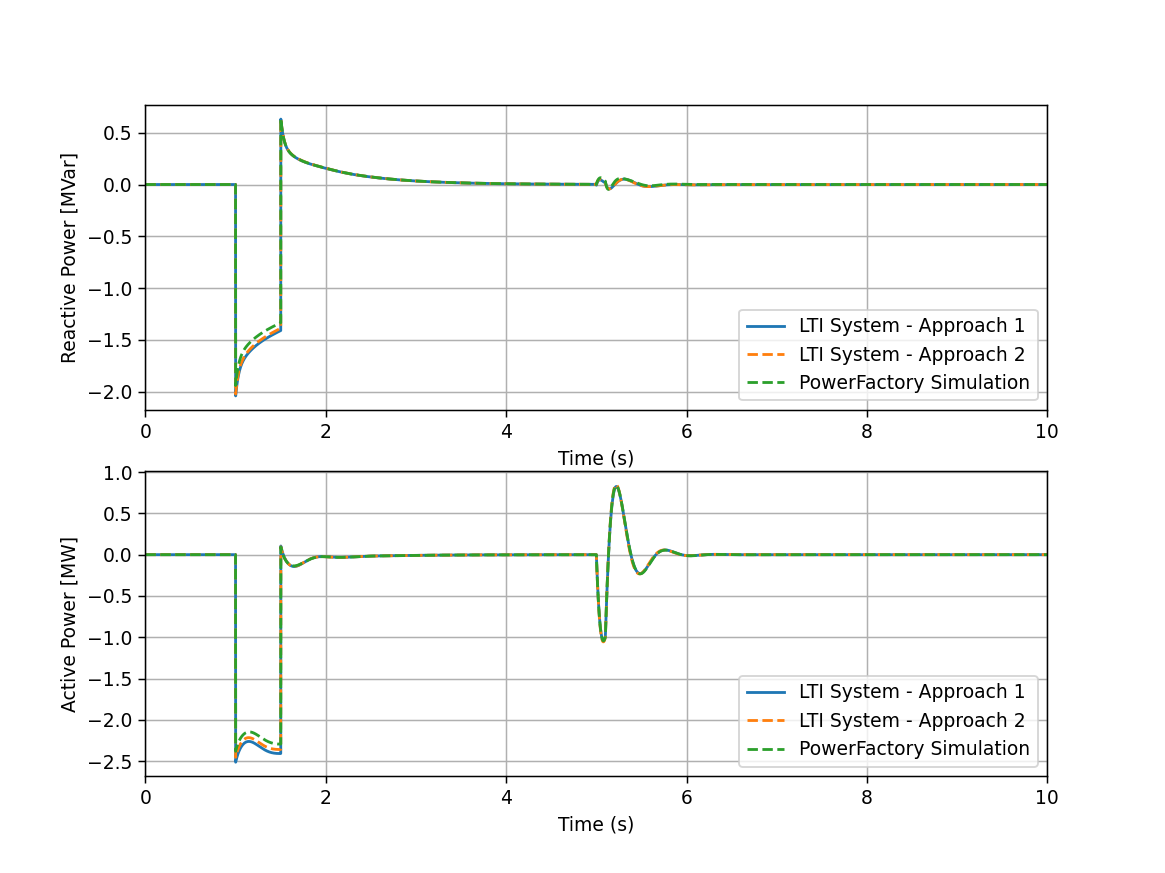

In [15]:
fig, axs = plt.subplots(2)
axs[0].plot(tout1, y1[:,0],label='LTI System - Approach 1')
axs[0].plot(tout2, y2[:,0],'--',label='LTI System - Approach 2')
axs[0].plot(res['SourcePCC.ElmVac\\m:Qsum:bus1'],'--',label='PowerFactory Simulation')
axs[0].set_ylabel('Reactive Power [MVar]')
axs[0].set_xlabel('Time (s)')
axs[0].set_xlim(0,10)
axs[0].legend()
axs[0].grid()
axs[1].plot(tout1, y1[:,1],label='LTI System - Approach 1')
axs[1].plot(tout2, y2[:,1],'--',label='LTI System - Approach 2')
axs[1].plot(res['SourcePCC.ElmVac\\m:Psum:bus1'],'--',label='PowerFactory Simulation')
axs[1].set_ylabel('Active Power [MW]')
axs[1].set_xlabel('Time (s)')
axs[1].set_xlim(0,10)
axs[1].legend()
axs[1].grid()
plt.show()

----

One can also look at the RMSE between the nonlinear and linear simulations to compare the two approaches.

In [16]:
def rmse(x,y):
    return np.sqrt(1/x.shape[0]*np.sum((x-y)**2))

Q = res['SourcePCC.ElmVac\\m:Qsum:bus1'].values[:-1]
P = res['SourcePCC.ElmVac\\m:Psum:bus1'].values[:-1]
print('------ RMSE for Approach 1 ------')
print('Reactive Power:', rmse(y1[:,0],Q))
print('Active Power:', rmse(y1[:,1],P),'\n')
print('------ RMSE for Approach 2 ------')
print('Reactive Power:', rmse(y2[:,0],Q))
print('Active Power:', rmse(y2[:,1],P))

------ RMSE for Approach 1 ------
Reactive Power: 0.019070650935459062
Active Power: 0.02665167806990526 

------ RMSE for Approach 2 ------
Reactive Power: 0.014507085003583439
Active Power: 0.01640056387704473


-----

The following plot show the comparison of eigenvalues of the $A$ matrix obtained from PowerFactory (same as approach 1) and the $A$ matrix obtained from the approach 2. 

<IPython.core.display.Javascript object>


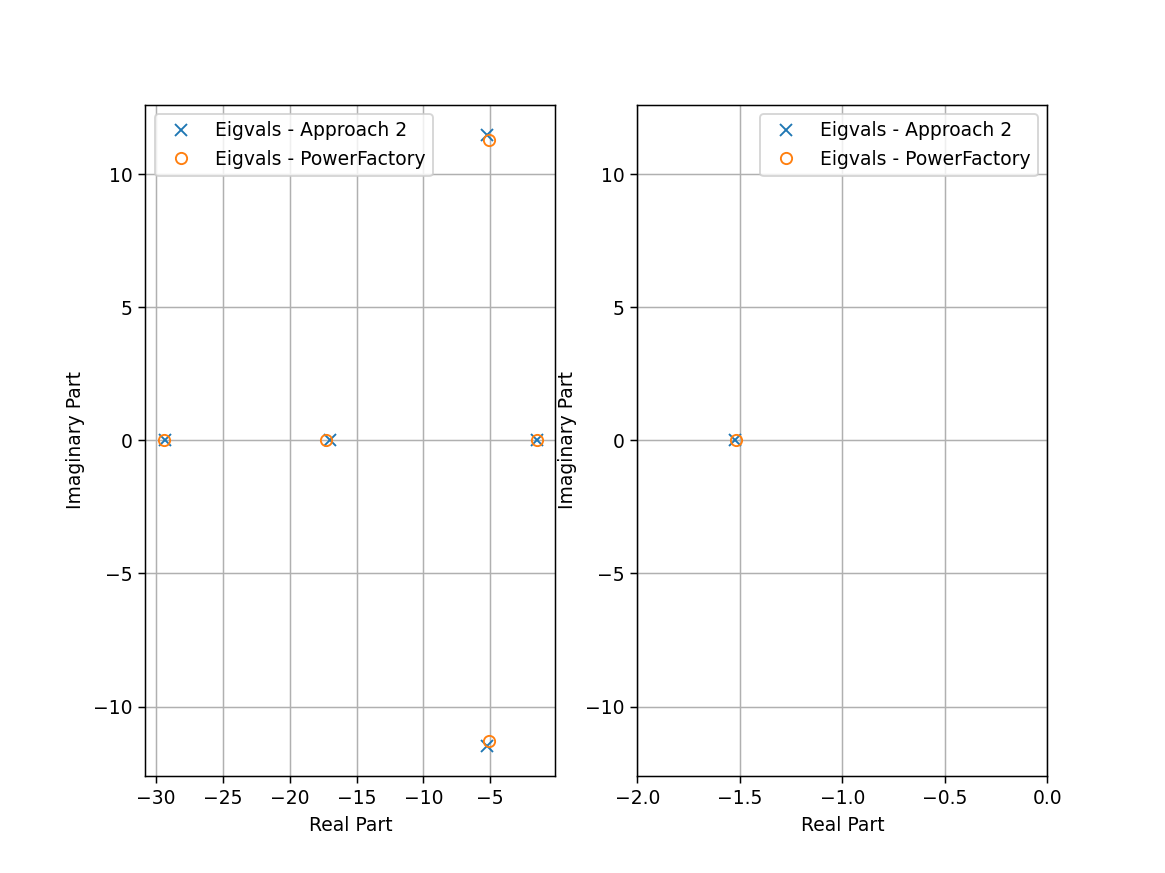

In [17]:
from scipy.linalg import eigvals
eigs2 = eigvals(A2)
eigspf = eigvals(A1)

fig, axs = plt.subplots(1,2)
axs[0].plot(np.real(eigs2), np.imag(eigs2),'x', label='Eigvals - Approach 2')
axs[0].plot(np.real(eigspf), np.imag(eigspf),'o', fillstyle='none', label='Eigvals - PowerFactory')
axs[0].set_xlabel('Real Part')
axs[0].set_ylabel('Imaginary Part')
axs[0].legend()
axs[0].grid()
axs[1].plot(np.real(eigs2), np.imag(eigs2),'x', label='Eigvals - Approach 2')
axs[1].plot(np.real(eigspf), np.imag(eigspf),'o', fillstyle='none', label='Eigvals - PowerFactory')
axs[1].set_xlim(-2,0)
axs[1].set_xlabel('Real Part')
axs[1].set_ylabel('Imaginary Part')
axs[1].legend()
axs[1].grid()
plt.show()

---

## Conclusions

- Approach #2 seems to be matching the time-domain response better than approach #1, but this might be due to a higher degree of freedom (in A matrix)


- This also indicates that the full model is not needed when creating dynamic equivalents of distribution networks to match the time-domain response.


- Approach #1 might be better suited for control design purposes since the "correct" A matrix is taken from PowerFactory 


- A more careful design of input signals is needed for Approach #2. I think there was not enough excitation in the input signals. Likely, some form of a Gaussian process would yield better results.


- Implementation of the approach #2 and it's input specifications are simpler than in the case of approach #1.
